In [1]:
#take boxes determined by marisol from kathleens biforcation data and calculate average environmental information for them
#want to calculate average SST, SSS, u^2+v^2, and var(u^2+v^2)
#recaluclate spd, dir from u,v after averaging in subset routine
import xarray as xr
import numpy as np
from math import pi
import datetime as dt
import os
from os.path import exists
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from datetime import *; from dateutil.relativedelta import *
from scipy.interpolate import make_interp_spline, BSpline
from scipy.signal import savgol_filter

dir_data_oscar = 'F:/data/sat_data/oscar/L4/oscar_third_deg/'
dir_data_sss='F:/data/model_data/CMEM/global-reanalysis-phy-001-030-monthly/'
dir_data_sst = 'F:/data/sst/cmc/CMC0.2deg/v2/monthly/' 
dir_data_ccmp='F:/data/sat_data/ccmp/v02.0/'
dir_data_mld='F:/data/model_data/godas/'
dir_figs = 'F:/data/NASA_biophysical/figures/'
dir_timeseries = 'F:/data/NASA_biophysical/timeseries_data/'

boxes_names = ['NPC','NPC_biforcation','CalCur','Alaska1','Alaska2']
#boxes_lon_min = [-160,-130,-125,-130,-148,-160,-130]
#boxes_lon_max = [-170,-140,-135,-140,-158,-170,-140]
#boxes_lat_center = [43.5,48.5,37.5,54.6,54.5,43.5,48.5]

#boxes_lon_min_180 = boxes_lon_min[:]
#boxes_lon_max_180 = boxes_lon_max[:]
#for i in range(0,5):
#    boxes_lon_min[i] += 360
#    boxes_lon_max[i] += 360

#for moving center point of boxes
def get_center(rlon):
    if rlon==-165:
        ds_lon = xr.open_dataset('F:/data/NASA_biophysical/timeseries_data/MonthlyBifurcationLat165.nc')
    if rlon==-135:
        ds_lon = xr.open_dataset('F:/data/NASA_biophysical/timeseries_data/MonthlyBifurcationLat135.nc')
    ds_lon['month']=np.ceil((ds_lon.year-ds_lon.year.astype('int'))*12).astype('int')
    ds_lon['iyear']=ds_lon.year.astype('int')
    ds_lon = ds_lon.assign_coords(yr=ds_lon.year)
    ds_lon = ds_lon.assign_coords(iyear=ds_lon.iyear)
    ds_lon = ds_lon.assign_coords(month=ds_lon.month)
    ds_out = ds_lon.copy(deep=True)    
    ds_lon.close()
    return ds_out

#trying to get into xarray properly
location_values = ['NPC','NPC_biforcation','CalCur','Alaska1','Alaska2','NPC-var','NPC-bi-var']
data = [-160,-130,-125,-130,-148,-160,-130]
lon1 = xr.DataArray(data, coords=[location_values], dims=['location'])
data = [-170,-140,-135,-140,-158,-170,-140]
lon2 = xr.DataArray(data, coords=[location_values], dims=['location'])
data = [43.5,48.5,37.5,54.6,54.5,43.5,48.5]
lat1 = xr.DataArray(data, coords=[location_values], dims=['location'])
data = [46,51,40,57,57,46,51]
lat2 = xr.DataArray(data, coords=[location_values], dims=['location'])
boxes = xr.Dataset({'lon_min':lon1,'lon_max':lon2,'lat_cen':lat1})

#boxes2 = xr.Dataset({'lon_min': (('location'), lon1),
#                 'lon_max': (('location'), lon2)},
#                { 'location': location_values})


#oscar - reran all monthly fies & climatology, updated through 2018, 2/1/2019
#ccmp - added RVort, from 6-hourly creating new monthly and climatology 2/1/2019 
#sst - updated all files, reprocessed monthly, climatology 2/1/2019
#sss - rerunning 2018, cal climatology 2/2/2019
#ssh - re running 2018 , cal climatology 2/2/2019
#mld - reran climatology, downloaded final 2018 file 2/1/2019

def get_climatology_filename(data_type):
    if data_type=='oscar':
        filename = dir_data_oscar + 'climatology_1993_2018_monthly_data_oscar.nc'        
    if data_type=='sss' or data_type=='ssh':
        filename = dir_data_sss + 'clim/climatology_1993_2017_mercatorglorys12v1_gl12_mean.nc'
    if data_type=='sst':
        filename = dir_data_sst + 'monthly_climatology_1992_2017_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc'
    if data_type == 'ccmp':
        filename = dir_data_ccmp + 'monthly/climatology_1988_2018_CCMP_Wind_Analysis_L3.0.nc'
    if data_type == 'mld':
        filename = dir_data_mld + 'monthly_climatology_dbss_obml_1992_2018.nc'
    return filename

def get_data_filename(data_type,lyr):
    if data_type == 'oscar':
        filename = dir_data_oscar + str(lyr) + 'monthly_data_oscar.nc'
    if data_type=='sss' or data_type=='ssh':
        filename = dir_data_sss + str(lyr) + '/'+ 'year_subset_mercatorglorys12v1_gl12_mean_' + str(lyr) + '.nc'
        if lyr==2018:
            filename = 'F:/data/model_data/CMEM/global-analysis-forecast-phys_001_015/monthly/year_subset_metoffice_coupled_orca025_GL4_SAL_b2018_dm20180208.nc'
    if data_type=='sst':
        filename = dir_data_sst + str(lyr) + 'monthly_average_' + '120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc'
    if data_type == 'ccmp':
        filename = dir_data_ccmp + 'monthly/CCMP_Wind_Analysis_' + str(lyr) + '_V02.0_L3.0_RSS.nc'
    if data_type == 'mld':
        filename = dir_data_mld + 'dbss_obml.' + str(lyr) + '.nc'
    return filename

def get_monthly_oscar(lyr,iclim):
    if iclim==0:
        filename = get_data_filename('oscar',lyr)
    else:
        filename = get_climatology_filename('oscar')
    print(filename)
    ds=xr.open_dataset(filename)
    ds = ds.sel(lon=slice(20.0,379.9))
    ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon').sortby('lat')
#    ds = ds.rename({'spd': 'data'})
    ds = ds.mean('depth')  #get rid of depth in index
    ds['spd']=(ds.u**2+ds.v**2)**.5
    ds['dir']=np.arctan2(ds.v,ds.u)* 180./pi
  #  ds=ds.drop('year')
    ds.close()
    return ds

def get_monthly_mld(lyr,iclim):
    if iclim==0:
        filename = get_data_filename('mld',lyr)
    else:
        filename = get_climatology_filename('mld')
    print(filename)
    ds=xr.open_dataset(filename)
    ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon').sortby('lat')
 #   ds = ds.rename({'dbss_obml': 'data'})
    ds.close()
    return ds

def get_monthly_ccmp(lyr,iclim):
    if iclim==0:
        filename = get_data_filename('ccmp',lyr)
    else:
        filename = get_climatology_filename('ccmp')
    print(filename)
    ds=xr.open_dataset(filename)
    ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon').sortby('lat')
    ds['spd']=(ds.uwnd**2+ds.vwnd**2)**.5
    ds['dir']=np.arctan2(ds.vwnd,ds.uwnd)* 180./pi    
#    ds = ds.rename({'spd': 'data'})
    ds.close()
    return ds

def get_monthly_sst(lyr,iclim):
    if iclim==0:
        filename = get_data_filename('sst',lyr)
    else:
        filename = get_climatology_filename('sst')
    print(filename)
    ds=xr.open_dataset(filename)
 #   ds = ds.rename({'analysed_sst': 'data'})
    ds.close()
    return ds

def get_monthly_sss(lyr,iclim):
    if iclim==0:
        filename = get_data_filename('sss',lyr)
    else:
        filename = get_climatology_filename('sss')
    if lyr<2018:
        ds=xr.open_dataset(filename,drop_variables=['mlotst','bottomT','sithick','siconc','usi','vsi','thetao','uo','vo','zos'])
    else:
        ds=xr.open_dataset(filename,drop_variables=['zos'])
    print(filename)
#    ds = ds.rename({'so': 'data'})
    ds.close()
    return ds

def get_monthly_ssh(lyr,iclim):
    if iclim==0:
        filename = get_data_filename('sss',lyr)  #same file as sss
    else:
        filename = get_climatology_filename('sss') #same file as sss
    print(filename)
    if lyr<2018:
        ds=xr.open_dataset(filename,drop_variables=['mlotst','bottomT','sithick','siconc','usi','vsi','thetao','uo','vo','so'])
    else:
        ds=xr.open_dataset(filename,drop_variables=['so'])
   # ds = ds.rename({'zos': 'data'})
    ds.close()
    return ds

def subset_data(ds_in,ireg,iclim_in):
    if ireg<5:
        tem = ds_in.sel(lon=slice(boxes.lon_max[ireg],boxes.lon_min[ireg]),
                         lat=slice((boxes.lat_cen[ireg]-2.5),(boxes.lat_cen[ireg]+2.5)))
        #print(tem.dims)
        ds_mean = tem.mean({'lat','lon'})
    else:
        if ireg==5:
            rlon=-165
        if ireg==6:
            rlon=-135
        boxes_cen = get_center(rlon)
        tem_lat = boxes_cen.sel(yr=slice(lyr,lyr+1))
        datasets=[]
        for im in range(0,12):
            if iclim_in==0:
                tem = ds_in.sel(time=slice(dt.datetime(lyr,im+1,1),dt.datetime(lyr,im+1,1) + relativedelta(months=+1)+dt.timedelta(days=-1)),
                                   lon=slice(rlon-5,rlon+5),
                                   lat=slice((tem_lat.latitude[im].data-2.5),(tem_lat.latitude[im].data+2.5)))
                #print(im, tem.dims)
                mn_new = tem.mean({'lat','lon'})
            if iclim_in==1:
                tem = ds_in.sel(month = im+1,
                                   lon=slice(rlon-5,rlon+5),
                                   lat=slice((tem_lat.latitude[im].data-2.5),(tem_lat.latitude[im].data+2.5)))
                #print(im, tem.dims)
                mn_new = tem.mean({'lat','lon'})
            datasets.append(mn_new)
            if iclim_in==0:
                ds_mean = xr.concat(datasets, dim='time')
            if iclim_in==1:
                ds_mean = xr.concat(datasets, dim='month')
    return ds_mean

#test reading -180 to 180, -90 to 90
iclim, lyr = 0,2017
#ds= get_monthly_oscar(lyr,iclim)
#ds= get_monthly_mld(lyr,iclim)
#ds= get_monthly_ccmp(lyr,iclim)
#ds= get_monthly_sst(lyr,iclim)
#ds= get_monthly_sss(lyr,iclim)
ds= get_monthly_ssh(lyr,iclim)
print(ds)
#ds.data[0,:,:].plot()
#ds.mlotst[0,:,:].plot(vmin=0,vmax=100) #density ocean mixed layer thickness
#ds.zos  #sea surface height above geod
#ds.uo  #eastward ocean velocity
#        if os.path.exists(filename):  
#            print(filename)


F:/data/model_data/CMEM/global-reanalysis-phy-001-030-monthly/2017/year_subset_mercatorglorys12v1_gl12_mean_2017.nc
<xarray.Dataset>
Dimensions:  (lat: 901, lon: 1800, time: 12)
Coordinates:
    depth    float32 ...
  * lat      (lat) float64 -90.0 -89.8 -89.6 -89.4 -89.2 ... 89.4 89.6 89.8 90.0
  * lon      (lon) float64 -180.0 -179.8 -179.6 -179.4 ... 179.4 179.6 179.8
  * time     (time) datetime64[ns] 2017-01-16T12:00:00 ... 2017-12-16T12:00:00
Data variables:
    zos      (time, lat, lon) float64 ...
Attributes:
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    institution:   

In [2]:
darray = ['oscar','mld','ccmp','sst','sss','ssh']
for itype in range(0,6):
    dtype = darray[itype]
    for lyr in range(2000,2019):
        iclim = 0
        if itype == 0:
            ds = get_monthly_oscar(lyr,0)
            ds2 = get_monthly_oscar(lyr,1)
        if itype == 1:
            ds = get_monthly_mld(lyr,0)
            ds2 = get_monthly_mld(lyr,1)
        if itype == 2:
            ds = get_monthly_ccmp(lyr,0)
            ds2 = get_monthly_ccmp(lyr,1)
        if itype == 3:
            ds = get_monthly_sst(lyr,0)
            ds2 = get_monthly_sst(lyr,1)
        if itype == 4:
            ds = get_monthly_sss(lyr,0)
            ds2 = get_monthly_sss(lyr,1)
        if itype == 5:
            ds = get_monthly_ssh(lyr,0)
            ds2 = get_monthly_ssh(lyr,1)  
#now iterate over regions
        for i in range(0,7):
            ds_mean = subset_data(ds,i,0)
            ds_mean_clim = subset_data(ds2,i,1)
            if itype == 0:  #if currents or winds need to recal spd dir from means of u and v
                ds_mean['spd']=(ds_mean.u**2+ds_mean.v**2)**.5
                ds_mean['dir']=np.arctan2(ds_mean.v,ds_mean.u)* 180./pi                
                ds_mean_clim['spd']=(ds_mean_clim.u**2+ds_mean_clim.v**2)**.5
                ds_mean_clim['dir']=np.arctan2(ds_mean_clim.v,ds_mean_clim.u)* 180./pi                
            if itype==2:  #if currents or winds need to recal spd dir from means of u and v
                ds_mean['spd']=(ds_mean.uwnd**2+ds_mean.vwnd**2)**.5
                ds_mean['dir']=np.arctan2(ds_mean.vwnd,ds_mean.uwnd)* 180./pi                
                ds_mean_clim['spd']=(ds_mean_clim.uwnd**2+ds_mean_clim.vwnd**2)**.5
                ds_mean_clim['dir']=np.arctan2(ds_mean_clim.vwnd,ds_mean_clim.uwnd)* 180./pi                
            ds_diff = ds_mean.groupby('time.month') - ds_mean_clim
            if i==0:
                ds_box = ds_mean
                ds_box_clim = ds_diff
            else:
                ds_box = xr.concat([ds_box,ds_mean],dim='box')
                ds_box_clim = xr.concat([ds_box_clim,ds_diff],dim='box')
        if lyr==2000:
            ds_newbox = ds_box
            ds_newbox_clim = ds_box_clim
        else:
            ds_newbox = xr.concat([ds_newbox,ds_box],dim='time')
            ds_newbox_clim = xr.concat([ds_newbox_clim,ds_box_clim],dim='time')
            #print(ds_newbox.box)
    filename_out = dir_timeseries + dtype + 'data_v2.nc'
    ds_newbox.to_netcdf(filename_out)
    filename_out_clim = dir_timeseries + dtype + 'data_minus_clim_v2.nc'
    ds_newbox_clim.to_netcdf(filename_out_clim)
    print('out!')


F:/data/sat_data/oscar/L4/oscar_third_deg/2000monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2001monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2002monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2003monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2004monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2005monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2006monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2007monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2008monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2009monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2010monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2011monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2012monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2013monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2014monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2015monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2016monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2017monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2018monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
out!
F:/data/model_data/godas/dbss_obml.2000.nc
F:/data/model_data/godas/monthly_climatology_dbss_obml_1992_2018.nc
F:/data/model_data/godas/dbss_obml.2001.nc
F:/data/model_data/godas/monthly_climatology_dbss_obml_1992_2018.nc
F:/data/model_data/godas/dbss_obml.2002.nc
F:/data/model_data/godas/monthly_climatology_dbss_obml_1992_2018.nc
F:/data/model_data/godas/dbss_obml.2003.nc
F:/data/model_data/godas/monthly_climatology_dbss_obml_1992_2018.nc
F:/data/model_data/godas/dbss_obml.2004.nc
F:/data/model_data/godas/monthly_climatology_dbss_obml_1992_2018.nc
F:/data/model_data/godas/dbss_obml.2005.nc
F:/data/model_data/godas/monthly_climatology_dbss_obml_1992_2018.nc
F:/data/model_data/godas/dbss_obml.2006.nc
F:/data/model_data/godas/monthly_climatology_dbss_obml_1992_2018.nc
F:/data/model_data/godas/dbss_obml.2007.nc
F:/data/model_data/godas/monthly_climatology_dbss_obml_1992_2018.nc
F:/data/model_data/go

F:/data/sst/cmc/CMC0.2deg/v2/monthly/2012monthly_average_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc
F:/data/sst/cmc/CMC0.2deg/v2/monthly/monthly_climatology_1992_2017_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc
F:/data/sst/cmc/CMC0.2deg/v2/monthly/2013monthly_average_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc
F:/data/sst/cmc/CMC0.2deg/v2/monthly/monthly_climatology_1992_2017_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc
F:/data/sst/cmc/CMC0.2deg/v2/monthly/2014monthly_average_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc
F:/data/sst/cmc/CMC0.2deg/v2/monthly/monthly_climatology_1992_2017_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc
F:/data/sst/cmc/CMC0.2deg/v2/monthly/2015monthly_average_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc
F:/data/sst/cmc/CMC0.2deg/v2/monthly/monthly_climatology_1992_2017_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc
F:/data/sst/cmc/CMC0.2deg/v2/mon

C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\lib\site-packages\xarr

out!
F:/data/model_data/CMEM/global-reanalysis-phy-001-030-monthly/2000/year_subset_mercatorglorys12v1_gl12_mean_2000.nc
F:/data/model_data/CMEM/global-reanalysis-phy-001-030-monthly/clim/climatology_1993_2017_mercatorglorys12v1_gl12_mean.nc
F:/data/model_data/CMEM/global-reanalysis-phy-001-030-monthly/2001/year_subset_mercatorglorys12v1_gl12_mean_2001.nc
F:/data/model_data/CMEM/global-reanalysis-phy-001-030-monthly/clim/climatology_1993_2017_mercatorglorys12v1_gl12_mean.nc
F:/data/model_data/CMEM/global-reanalysis-phy-001-030-monthly/2002/year_subset_mercatorglorys12v1_gl12_mean_2002.nc
F:/data/model_data/CMEM/global-reanalysis-phy-001-030-monthly/clim/climatology_1993_2017_mercatorglorys12v1_gl12_mean.nc
F:/data/model_data/CMEM/global-reanalysis-phy-001-030-monthly/2003/year_subset_mercatorglorys12v1_gl12_mean_2003.nc
F:/data/model_data/CMEM/global-reanalysis-phy-001-030-monthly/clim/climatology_1993_2017_mercatorglorys12v1_gl12_mean.nc
F:/data/model_data/CMEM/global-reanalysis-phy-0

C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\lib\site-packages\xarr

out!


ccmp
F:/data/sat_data/ccmp/v02.0/monthly/CCMP_Wind_Analysis_2000_V02.0_L3.0_RSS.nc
oscar
F:/data/sat_data/oscar/L4/oscar_third_deg/2000monthly_data_oscar.nc
sst
F:/data/sst/cmc/CMC0.2deg/v2/monthly/2000monthly_average_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc
sss
F:/data/model_data/CMEM/global-reanalysis-phy-001-030-monthly/2000/year_subset_mercatorglorys12v1_gl12_mean_2000.nc
mld
F:/data/model_data/godas/dbss_obml.2000.nc


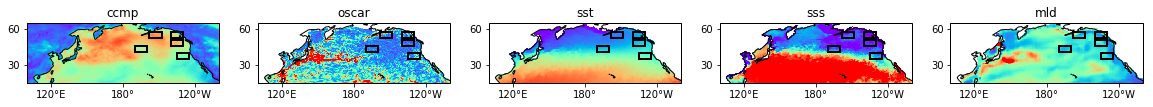

In [3]:
#make oscar timeseries
#for ibox in range(0,2): #5):
#
from matplotlib.lines import Line2D 
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import cartopy.crs as ccrs
darray = ['ccmp','oscar','sst','sss','mld']
fig, axarr = plt.subplots(1, 5,figsize=(20,6),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

for itype in range(0,5):
    dtype = darray[itype]
    print(dtype)
    for lyr in range(2000,2001):
        filename = get_data_filename(dtype,lyr)
        if os.path.exists(filename):  
            print(filename)
            ds=xr.open_dataset(filename)
            ax0 = axarr[itype]
            if itype==0:
                im = ax0.pcolormesh(ds.lon.values,ds.lat.values,ds.spd[0,:,:],transform=ccrs.PlateCarree(),cmap='rainbow');
            if itype==1:
                im = ax0.pcolormesh(ds.lon.values,ds.lat.values,ds.spd[0,0,:,:],transform=ccrs.PlateCarree(),cmap='rainbow',vmin=0,vmax=0.3);
            if itype==2:
                im = ax0.pcolormesh(ds.lon.values,ds.lat.values,ds.analysed_sst[0,:,:],transform=ccrs.PlateCarree(),cmap='rainbow');
            if itype==3:
                im = ax0.pcolormesh(ds.lon.values,ds.lat.values,ds.so[0,:,:],transform=ccrs.PlateCarree(),cmap='rainbow',vmin=32.5,vmax=34.5);
            if itype==4:
                im = ax0.pcolormesh(ds.lon.values,ds.lat.values,ds.dbss_obml[0,:,:],transform=ccrs.PlateCarree(),cmap='rainbow',vmin=10,vmax=200);
            ax0.set_global(); ax0.coastlines();
            ax0.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
            ax0.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            ax0.xaxis.set_major_formatter(lon_formatter)
            ax0.set_xlim(-80,80); ax0.set_ylim(15,65)
            ax0.set_title(darray[itype])                           
            for i in range(0,5):
                x=[boxes.lon_min[i]+180,boxes.lon_max[i]+180]
                y=[boxes.lat_cen[i]-2.5,boxes.lat_cen[i]-2.5]
                line = Line2D(x, y, linewidth=2, color='black')
                ax0.add_line(line)
                x=[boxes.lon_max[i]+180,boxes.lon_min[i]+180]
                y=[boxes.lat_cen[i]+2.5,boxes.lat_cen[i]+2.5]
                line = Line2D(x, y, linewidth=2, color='black')
                ax0.add_line(line)
                x=[boxes.lon_min[i]+180,boxes.lon_min[i]+180]
                y=[boxes.lat_cen[i]-2.5,boxes.lat_cen[i]+2.5]
                line = Line2D(x, y, linewidth=2, color='black')
                ax0.add_line(line)
                x=[boxes.lon_max[i]+180,boxes.lon_max[i]+180]
                y=[boxes.lat_cen[i]-2.5,boxes.lat_cen[i]+2.5]
                line = Line2D(x, y, linewidth=2, color='black')
                ax0.add_line(line)
                #ax0.get_lines()[0].set_color("black")
fig.savefig(dir_figs + 'region.png', dpi=100)           

In [4]:
#filename_out_clim = dir_timeseries + dtype + 'data_minus_clim.nc'
data_type= 'data_v2.nc'
data_type2= 'data_minus_clim_v2.nc'
dtype = 'oscar'
filename = dir_timeseries + dtype + data_type
ds_oscar = xr.open_dataset(filename)
ds_oscar.close()
filename = dir_timeseries + dtype + data_type2
ds_oscar_clim = xr.open_dataset(filename)
ds_oscar_clim.close()
dtype = 'sst'
filename = dir_timeseries + dtype + data_type
ds_sst = xr.open_dataset(filename)
ds_sst.close()
filename = dir_timeseries + dtype + data_type2
ds_sst_clim = xr.open_dataset(filename)
ds_sst_clim.close()
dtype = 'ccmp'
filename = dir_timeseries + dtype + data_type
ds_ccmp = xr.open_dataset(filename)
ds_ccmp.close()
filename = dir_timeseries + dtype + data_type2
ds_ccmp_clim = xr.open_dataset(filename)
ds_ccmp_clim.close()
dtype = 'sss'
filename = dir_timeseries + dtype + data_type
dtype, filename = 'sss', dir_timeseries + dtype + data_type
ds_sss = xr.open_dataset(filename)
ds_sss.close()
filename = dir_timeseries + dtype + data_type2
ds_sss_clim = xr.open_dataset(filename)
ds_sss_clim.close()
dtype = 'mld'
filename = dir_timeseries + dtype + data_type
dtype, filename = 'mld', dir_timeseries + dtype + data_type
ds_mld = xr.open_dataset(filename)
ds_mld.close()
filename = dir_timeseries + dtype + data_type2
ds_mld_clim = xr.open_dataset(filename)
ds_mld_clim.close()


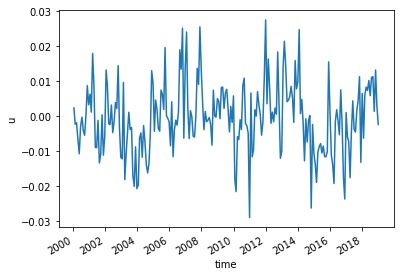

In [5]:
ds_oscar_clim.u[4,:].plot()

In [ ]:
lyr = 2013
ds2 = get_monthly_oscar(lyr,1)
ds2

In [ ]:
#ds2_subset = ds2.sel(lat=slice(30,65),lon=slice(-179,-100))
#ds2_subset.dir[0,:,:].plot()
ds2_subset = ds2.sel(lat=slice(54.5-2.5,54.5+2.5),lon=slice(-158,-148))
ds2_subset.dir[0,:,:].plot()
ds2_subset_mean = ds2_subset.mean({'lat','lon'})

In [ ]:
np.arctan2(ds2_subset_mean.v,ds2_subset_mean.u)*180/pi

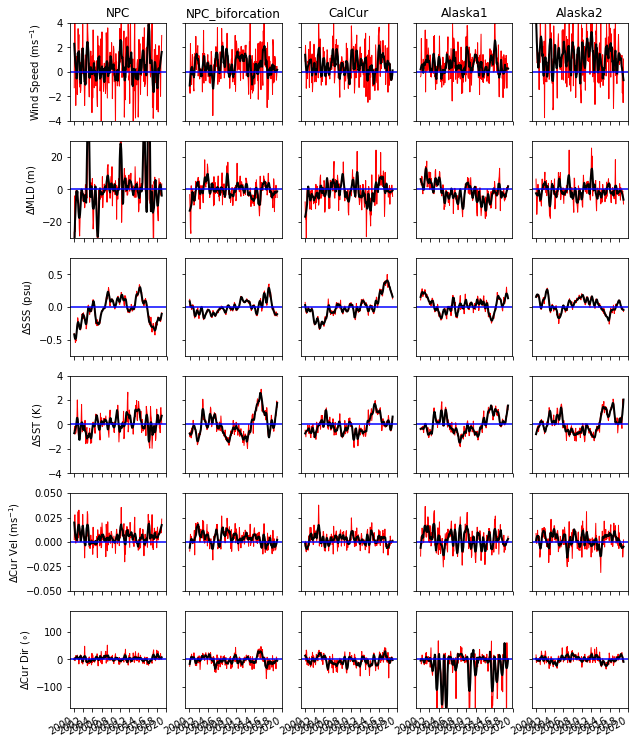

In [8]:
#plot only anomalies, use variable latitudes
boxes_names = ['NPC','NPC_biforcation','CalCur','Alaska1','Alaska2','NPC','NPC-biforcation']
fig, axarr = plt.subplots(6, 5,figsize=(10,14))
#fig.clf()
ax_order = [0,0,2,3,4,0,1]
for iregion in range(2,7):  #use var lat ratehr than static npc & bi
    for icol in range(0,5):
        if icol==0:
            ds = ds_ccmp_clim
            ax = axarr[0,ax_order[iregion]]
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.spd, 11, 2)
            ax.plot(ds.time[:],tem.spd, label = 'Anomaly',color='red',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='black',linewidth=2)
            ax.axhline(y=0.0, color='blue', linestyle='-')
            ax.set_title(boxes_names[ax_order[iregion]])
            if iregion==5:
                ax.set_ylabel('Wind Speed (ms$^{-1}$)')
            else:
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(-4,4)
        if icol==0:
            ds = ds_mld_clim
            ax = axarr[1,ax_order[iregion]]
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.dbss_obml, 11, 2)
            ax.plot(ds.time[:],tem.dbss_obml, label = 'Anomaly',color='red',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            if iregion==5:
                ax.set_ylabel('$\Delta$MLD (m)')
            else:
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(-30,30)
        if icol==1:
            ds = ds_sss_clim
            ax = axarr[2,ax_order[iregion]]
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.so, 11, 2)
            ax.plot(ds.time[:],tem.so, label = 'Anomaly',color='r',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            if iregion==5:
                ax.set_ylabel('$\Delta$SSS (psu)')
            else:
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(-.75,.75)
        if icol==2:
            ds = ds_sst_clim
            ax = axarr[3,ax_order[iregion]]
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.analysed_sst, 11, 2)
            ax.plot(ds.time[:],tem.analysed_sst, label = 'Anomaly',color='r',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            if iregion==5:
                ax.set_ylabel('$\Delta$SST (K)')
            else:
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(-4,4)
        if icol==3:
            ds = ds_oscar_clim
            ax = axarr[4,ax_order[iregion]]
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.spd, 11, 2)
            ax.plot(ds.time[:],tem.spd, label = 'Anomaly',color='r',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            if iregion==5:
                ax.set_ylabel('$\Delta$Cur Vel (ms$^{-1}$)')
            else:
                ax.set_yticklabels('')
            ax.set_ylim(-0.05,0.05)
        if icol==4:
            #ds = ds_oscar
            ds = ds_oscar_clim
            ax = axarr[5,ax_order[iregion]]
            tem = ds.isel(box=iregion)
#            tem,tem2 = ds.isel(box=iregion),ds2.isel(box=iregion)
            #dif = tem - tem2
            ds_smoothed = savgol_filter(tem.dir, 11, 2)
            ax.plot(ds.time[:],tem.dir, label = 'Anomaly',color='r',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            if iregion==5:
                ax.set_ylabel('$\Delta$Cur Dir ($\circ$)')
            else:
                ax.set_yticklabels('')
            ax.set_ylim(-180,180)
fig.autofmt_xdate()
fig.savefig(dir_figs + 'timeseries_anomaly.png', dpi=100)

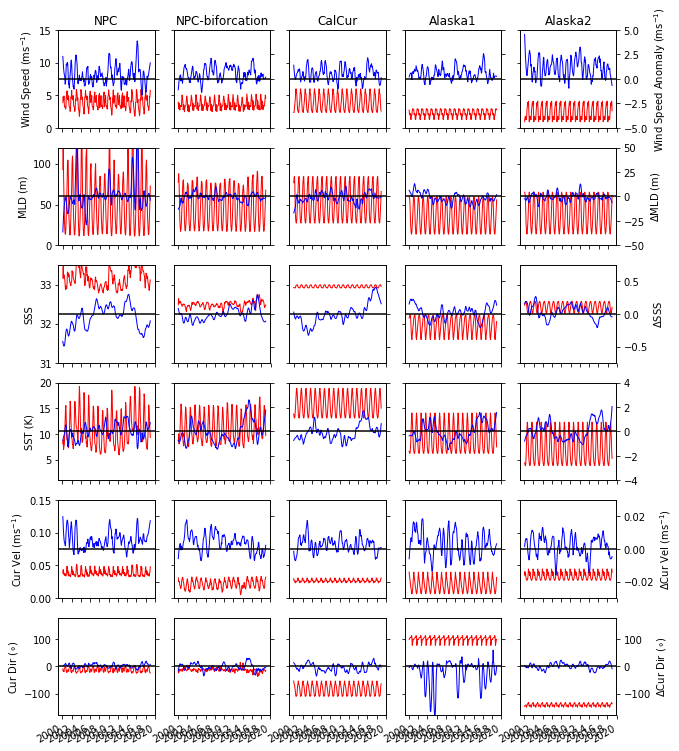

In [9]:
boxes_names = ['NPC','NPC_biforcation','CalCur','Alaska1','Alaska2','NPC','NPC-biforcation']
fig, axarr = plt.subplots(6, 5,figsize=(10,14))
#fig.clf()
ax_order = [0,0,2,3,4,0,1]
for iregion in range(2,7):  #use var lat ratehr than static npc & bi
    for icol in range(0,5):
        if icol==0:
            ds = ds_ccmp
            ds_clim = ds_ccmp_clim
            ax = axarr[0,ax_order[iregion]]
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds_clim.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.spd, 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.spd[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds.spd[iregion,:]
                                   -ds_clim.spd[iregion,:],label = 'Climatology',color='red',linewidth=1)
            ax.set_title(boxes_names[iregion])
            if iregion==4:
                ax2.set_ylabel('Wind Speed Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==5:
                ax2.set_yticklabels('')
                ax.set_ylabel('Wind Speed (ms$^{-1}$)')
            else:
                ax2.set_yticklabels('')
                ax.set_yticklabels('')
            ax2.set_xticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(0,15)
            ax2.set_ylim(-5,5)
        if icol==0:
            ds = ds_mld
            ds_clim = ds_mld_clim
            ax = axarr[1,ax_order[iregion]]
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ax.plot(ds.time[:],ds.dbss_obml[iregion,:]
                                   -ds_clim.dbss_obml[iregion,:],label = 'clim',color='red',linewidth=1)
            tem = ds_clim.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.dbss_obml, 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
          #  ax2.plot(ds.time[:],ds_clim.dbss_obml[iregion,:], label = 'MLD minus clim',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            if iregion==4:
                ax2.set_ylabel('$\Delta$MLD (m)')
                ax.set_yticklabels('')
            elif iregion==5:
                ax2.set_yticklabels('')
                ax.set_ylabel('MLD (m)')        
            else:
                ax2.set_yticklabels('')
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            ax2.set_xticklabels('')
            ax.set_ylim(0,120)
            ax2.set_ylim(-50,50)
        if icol==1:
            ds = ds_sss
            ds_clim = ds_sss_clim
            ax = axarr[2,ax_order[iregion]]
           # ax.plot(ds.time[:],ds.so[iregion,:]-33,label = 'SSS')
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds_clim.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.so, 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.so[iregion,:], label = 'SSS minus clim',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds.so[iregion,:]
                                   -ds_clim.so[iregion,:],label = 'clim',color='red',linewidth=1)

            if iregion==4:
                ax2.set_ylabel('$\Delta$SSS')
                ax.set_yticklabels('')
            elif iregion==5:
                ax2.set_yticklabels('')
                ax.set_ylabel('SSS')
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_xticklabels('')
            ax2.set_xticklabels('')
            ax.set_ylim(31,33.5)
            ax2.set_ylim(-.75,.75)
        if icol==2:
            ds = ds_sst
            ds_clim = ds_sst_clim
            ax = axarr[3,ax_order[iregion]]
           # ax.plot(ds.time[:],ds.analysed_sst[iregion,:]-273.15,label = 'SST')
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds_clim.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.analysed_sst, 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.analysed_sst[iregion,:], label = 'SST minus clim',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds.analysed_sst[iregion,:]
                                   -ds_clim.analysed_sst[iregion,:]-273.15,label = 'clim',color='red',linewidth=1)
            if iregion==4:
                ax2.set_xlabel('$\Delta$SST')
                ax.set_yticklabels('')
            elif iregion==5:
                ax2.set_yticklabels('')
                ax.set_ylabel('SST (K)')
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_xticklabels('')
            ax2.set_xticklabels('')
            ax.set_ylim(1,20)
            ax2.set_ylim(-4,4)
        if icol==3:
            ds = ds_oscar
            ds_clim = ds_oscar_clim
            ax = axarr[4,ax_order[iregion]]
            #ax.plot(ds.time[:],ds.spd[iregion,:],label = 'Current Speed')
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds_clim.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.spd, 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.spd[iregion,:], label = 'Current minus clim',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds.spd[iregion,:]
                                   -ds_clim.spd[iregion,:],label = 'clim',color='red',linewidth=1)
            if iregion==4:
                ax2.set_ylabel('$\Delta$Cur Vel (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==5:
                ax2.set_yticklabels('')
                ax.set_ylabel('Cur Vel (ms$^{-1}$)')            #if iregion==0:
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_ylim(0,.15)
            ax2.set_ylim(-0.03,0.03)
        if icol==4:
            ds = ds_oscar
            ds2 = ds_oscar_clim
            ax = axarr[5,ax_order[iregion]]
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds_clim.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.dir, 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds.dir[iregion,:]
                                   -ds_clim.dir[iregion,:],label = 'clim',color='red',linewidth=1)
            if iregion==4:
                ax2.set_ylabel('$\Delta$Cur Dir ($\circ$)')
                ax.set_yticklabels('')
            elif iregion==5:
                ax2.set_yticklabels('')
                ax.set_ylabel('Cur Dir ($\circ$)')            #if iregion==0:
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_ylim(-180,180)
            ax2.set_ylim(-180,180)
#print(ax.shape)
#fig.tight_layout()
fig.autofmt_xdate()
fig.savefig(dir_figs + 'timeseries_anomaly2.png', dpi=100)

In [17]:
len(ds.time)

228

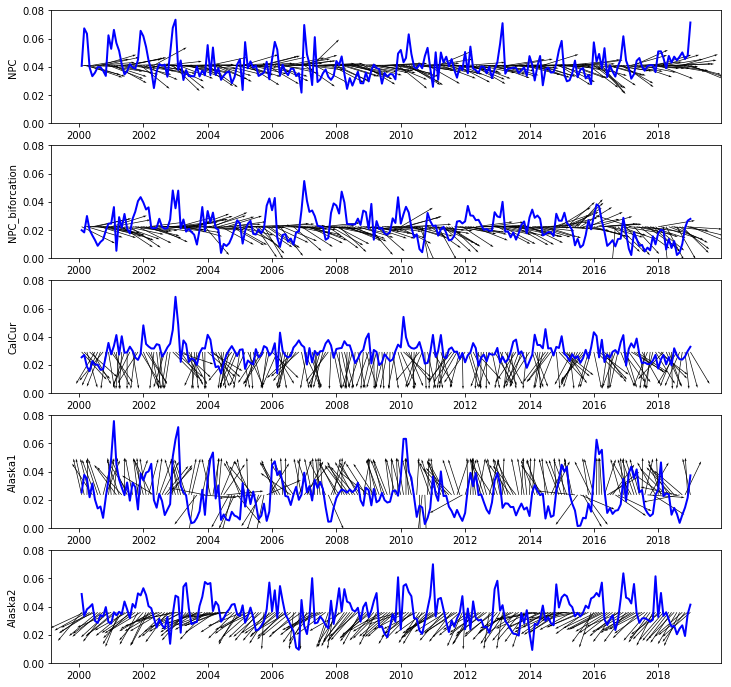

In [31]:
fig, ax = plt.subplots(5, 1,figsize=(12, 12))
for iregion in range(0,5): #5):
    ax[iregion].plot(ds.time[:], ds.spd[iregion,:], linewidth=2, color='blue')
    arrow_scaler = .001
    for i in range(0,len(ds.time),1):
        u = arrow_scaler*ds.u[iregion,i] #-1*np.sin((np.pi/180)*(ds.dir[iregion,i]))
        v = arrow_scaler*ds.v[iregion,i] #-1*np.cos((np.pi/180)*(ds.dir[iregion,i]))
        ax[iregion].quiver(ds.time[i].values,ds.spd[iregion,:].mean(),u.values,v.values,width=0.001)
        ax[iregion].set_ylim(0,.08)
        ax[iregion].set_ylabel(boxes_names[iregion])
fig.savefig(dir_figs + 'timeseries_winds.png', dpi=100)

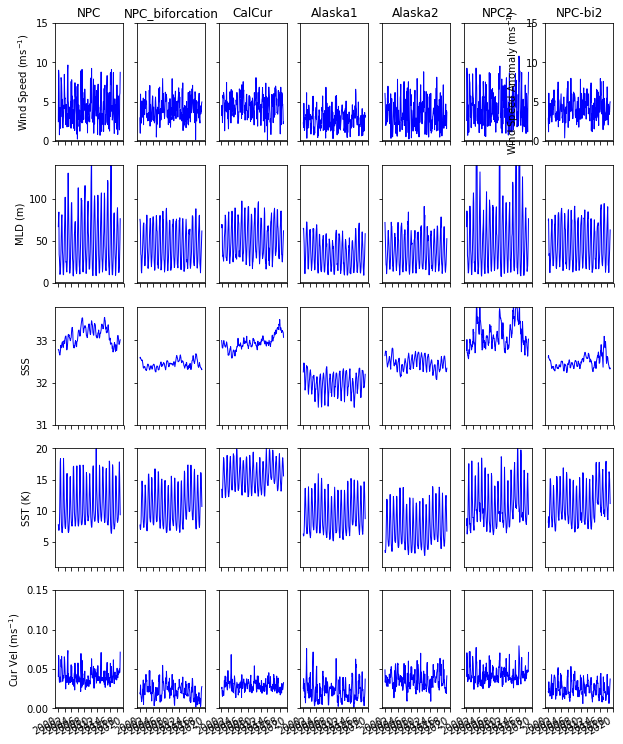

In [32]:
boxes_names = ['NPC','NPC_biforcation','CalCur','Alaska1','Alaska2','NPC2','NPC-bi2']
fig, axarr = plt.subplots(5, 7,figsize=(10,14))
#fig.clf()
for iregion in range(0,7):
    for icol in range(0,5):
        if icol==0:
            ds = ds_ccmp
            ds_clim = ds_ccmp_clim
            ax = axarr[0,iregion]
#            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.spd, 11, 2)
            ax.plot(ds.time[:],tem.spd, label = 'Data',color='blue',linewidth=1)
#            ax.plot(ds.time[:],ds_smoothed, label = 'Data',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.spd[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax.axhline(y=0.0, color='k', linestyle='-')
            #ax.plot(ds.time[:],ds.spd[iregion,:]
            #                       -ds_clim.spd[iregion,:],label = 'Climatology',color='red',linewidth=1)
            ax.set_title(boxes_names[iregion])
            if iregion==6:
                ax.set_ylabel('Wind Speed Anomaly (ms$^{-1}$)')
                #ax.set_yticklabels('')
            elif iregion==0:
                #ax2.set_yticklabels('')
                ax.set_ylabel('Wind Speed (ms$^{-1}$)')
            else:
                #ax2.set_yticklabels('')
                ax.set_yticklabels('')
            #ax2.set_xticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(0,15)
            #ax2.set_ylim(-5,5)
#            ax.set_xlim(2000,2019)
#            ax2.set_xlim(2000,2019)
        if icol==0:
            ds = ds_mld
            ds_clim = ds_mld_clim
            ax = axarr[1,iregion]
           # ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
#            ax.plot(ds.time[:],ds.dbss_obml[iregion,:]
#                                   -ds_clim.dbss_obml[iregion,:],label = 'clim',color='red',linewidth=1)
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.dbss_obml, 11, 2)
#            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
            ax.plot(ds.time[:],tem.dbss_obml, label = 'Anomaly',color='blue',linewidth=1)
          #  ax2.plot(ds.time[:],ds_clim.dbss_obml[iregion,:], label = 'MLD minus clim',color='blue',linewidth=1)
            ax.axhline(y=0.0, color='k', linestyle='-')
            if iregion==6:
             #   ax2.set_ylabel('$\Delta$MLD (m)')
                ax.set_yticklabels('')
            elif iregion==0:
             #   ax2.set_yticklabels('')
                ax.set_ylabel('MLD (m)')        
            else:
             #   ax2.set_yticklabels('')
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            #ax2.set_xticklabels('')
            ax.set_ylim(0,140)
            #ax2.set_ylim(-50,50)
        if icol==1:
            ds = ds_sss
            ds_clim = ds_sss_clim
            ax = axarr[2,iregion]
           # ax.plot(ds.time[:],ds.so[iregion,:]-33,label = 'SSS')
#            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.so, 11, 2)
#            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly Smoothed',color='blue',linewidth=1)
            ax.plot(ds.time[:],tem.so, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.so[iregion,:], label = 'SSS minus clim',color='blue',linewidth=1)
            ax.axhline(y=0.0, color='k', linestyle='-')
            #ax.plot(ds.time[:],ds.so[iregion,:]
            #                       -ds_clim.so[iregion,:],label = 'clim',color='red',linewidth=1)

            if iregion==6:
              #  ax2.set_ylabel('$\Delta$SSS')
                ax.set_yticklabels('')
            elif iregion==0:
               # ax2.set_yticklabels('')
                ax.set_ylabel('SSS')
            else:
                ax.set_yticklabels('')
                #ax2.set_yticklabels('')
            ax.set_xticklabels('')
            #ax2.set_xticklabels('')
            ax.set_ylim(31,33.8)
            #ax2.set_ylim(-.75,.75)
        if icol==2:
            ds = ds_sst
            ds_clim = ds_sst_clim
            ax = axarr[3,iregion]
           # ax.plot(ds.time[:],ds.analysed_sst[iregion,:]-273.15,label = 'SST')
  #          ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.analysed_sst, 11, 2)
            ax.plot(ds.time[:],tem.analysed_sst-273.15, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.analysed_sst[iregion,:], label = 'SST minus clim',color='blue',linewidth=1)
            ax.axhline(y=0.0, color='k', linestyle='-')
            #ax.plot(ds.time[:],ds.analysed_sst[iregion,:]
            #                       -ds_clim.analysed_sst[iregion,:]-273.15,label = 'clim',color='red',linewidth=1)
            if iregion==6:
             #   ax2.set_xlabel('$\Delta$SST')
                ax.set_yticklabels('')
            elif iregion==0:
              #  ax2.set_yticklabels('')
                ax.set_ylabel('SST (K)')
            else:
                ax.set_yticklabels('')
               # ax2.set_yticklabels('')
            ax.set_xticklabels('')
            #ax2.set_xticklabels('')
            ax.set_ylim(1,20)
            #ax2.set_ylim(-4,4)
        if icol==3:
            ds = ds_oscar
            ds_clim = ds_oscar_clim
            ax = axarr[4,iregion]
            #ax.plot(ds.time[:],ds.spd[iregion,:],label = 'Current Speed')
            #ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.spd, 11, 2)
            ax.plot(ds.time[:],tem.spd, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.spd[iregion,:], label = 'Current minus clim',color='blue',linewidth=1)
            ax.axhline(y=0.0, color='k', linestyle='-')
           # ax.plot(ds.time[:],ds.spd[iregion,:]
           #                        -ds_clim.spd[iregion,:],label = 'clim',color='red',linewidth=1)
            if iregion==6:
           #     ax2.set_ylabel('$\Delta$Cur Vel (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
           #     ax2.set_yticklabels('')
                ax.set_ylabel('Cur Vel (ms$^{-1}$)')            #if iregion==0:
            else:
                ax.set_yticklabels('')
           #     ax2.set_yticklabels('')
            ax.set_ylim(0,.15)
           # ax2.set_ylim(-0.03,0.03)
        #    axarr[iregion, 0].legend()
          #  for tick in ax.get_xticklabels():
          #      tick.set_rotation(45)#fig.show()
#print(ax.shape)
#fig.tight_layout()
fig.autofmt_xdate()
fig.savefig(dir_figs + 'timeseries_data.png', dpi=100)

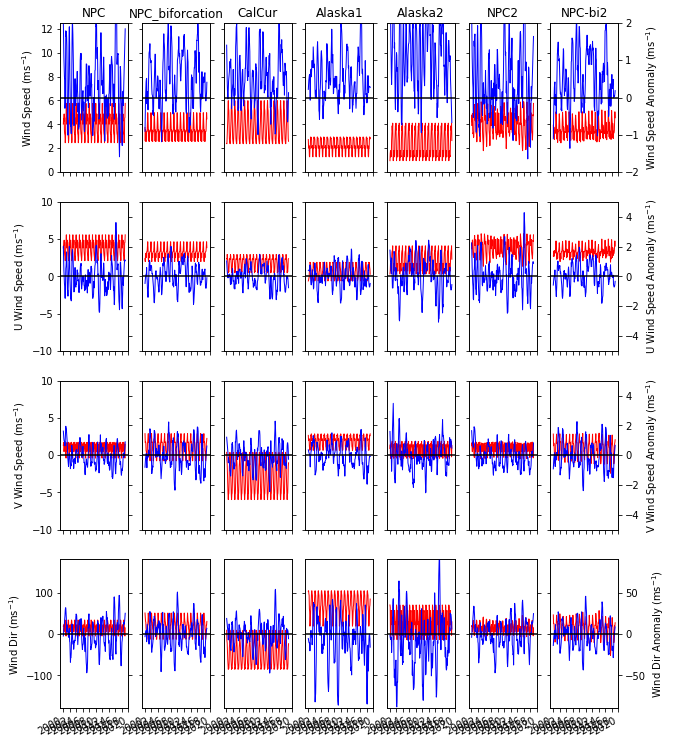

In [33]:
#same type of figure but this time show wind spd, u, v, dir from ccmp data
fig, axarr = plt.subplots(4, 7,figsize=(10,14))
#fig.clf()
for iregion in range(0,7):
    for icol in range(0,5):
        if icol==0:
            ds = ds_ccmp
            ds_clim = ds_ccmp_clim
            ax = axarr[0,iregion]
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ds_smoothed = savgol_filter(ds_clim.spd[iregion,:], 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            #ax2.plot(ds.time[:],ds_clim.spd[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax.plot(ds.time[:],ds.spd[iregion,:]
                                   -ds_clim.spd[iregion,:],label = 'Climatology',color='red',linewidth=1)
            ax.set_title(boxes_names[iregion])
            if iregion==6:
                ax2.set_ylabel('Wind Speed Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
                ax2.set_yticklabels('')
                ax.set_ylabel('Wind Speed (ms$^{-1}$)')
            else:
                ax2.set_yticklabels('')
                ax.set_yticklabels('')
            ax2.set_xticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(0,12.5)
            ax2.set_ylim(-2,2)
        if icol==0:
            ax = axarr[1,iregion]
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ds_smoothed = savgol_filter(ds_clim.uwnd[iregion,:], 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            #ax2.plot(ds.time[:],ds_clim.uwnd[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax.plot(ds.time[:],ds.uwnd[iregion,:]
                                   -ds_clim.uwnd[iregion,:],label = 'Climatology',color='red',linewidth=1)
            if iregion==6:
                ax2.set_ylabel('U Wind Speed Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
                ax2.set_yticklabels('')
                ax.set_ylabel('U Wind Speed (ms$^{-1}$)')
            else:
                ax2.set_yticklabels('')
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            ax2.set_xticklabels('')
            ax.set_ylim(-10,10)
            ax2.set_ylim(-5,5)
        if icol==1:
            ax = axarr[2,iregion]
           # ax.plot(ds.time[:],ds.so[iregion,:]-33,label = 'SSS')
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ds_smoothed = savgol_filter(ds_clim.vwnd[iregion,:], 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.vwnd[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds.vwnd[iregion,:]
                                   -ds_clim.vwnd[iregion,:],label = 'Climatology',color='red',linewidth=1)
            if iregion==6:
                ax2.set_ylabel('V Wind Speed Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
                ax2.set_yticklabels('')
                ax.set_ylabel('V Wind Speed (ms$^{-1}$)')
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_xticklabels('')
            ax2.set_xticklabels('')
            ax.set_ylim(-10,10)
            ax2.set_ylim(-5,5)
        if icol==2:
            ax = axarr[3,iregion]
           # ax.plot(ds.time[:],ds.analysed_sst[iregion,:]-273.15,label = 'SST')
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ds_smoothed = savgol_filter(ds_clim.dir[iregion,:], 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.dir[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds.dir[iregion,:]
                                   -ds_clim.dir[iregion,:],label = 'Climatology',color='red',linewidth=1)
            if iregion==6:
                ax2.set_ylabel('Wind Dir Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
                ax2.set_yticklabels('')
                ax.set_ylabel('Wind Dir (ms$^{-1}$)')
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_ylim(-180,180)
            ax2.set_ylim(-90,90)
#print(ax.shape)
#fig.tight_layout()
fig.autofmt_xdate()
fig.savefig(dir_figs + 'CCMP_timeseries.png', dpi=100)

In [ ]:
ds_oscar_clim

In [ ]:
from scipy.signal import savgol_filter

#same type of figure but this time show current spd, u, v, dir from oscar data
fig, axarr = plt.subplots(4, 5,figsize=(10,10))
#fig.clf()
for iregion in range(0,5):
    for icol in range(0,5):
        if icol==0:
            ds = ds_oscar.mean('depth')
            ds_clim = ds_oscar_clim.mean('depth')
            ax = axarr[0,iregion]
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ds_smoothed = savgol_filter(ds_clim.spd[iregion,:], 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
            #ax2.plot(ds.time[:],ds_clim.spd[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax.plot(ds.time[:],ds.spd[iregion,:]
                                   -ds_clim.spd[iregion,:],label = 'Climatology',color='red',linewidth=1)
            ax.set_title(boxes_names[iregion])
            if iregion==4:
                ax2.set_ylabel('Current Speed Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
                ax2.set_yticklabels('')
                ax.set_ylabel('Current Speed (ms$^{-1}$)')
            else:
                ax2.set_yticklabels('')
                ax.set_yticklabels('')
            ax2.set_xticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(0.04,.12)
            ax2.set_ylim(-.1,.1)
        if icol==0:
            ax = axarr[1,iregion]
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ds_smoothed = savgol_filter(ds_clim.u[iregion,:], 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
            #ax2.plot(ds.time[:],ds_clim.uwnd[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax.plot(ds.time[:],ds.u[iregion,:]
                                   -ds_clim.u[iregion,:],label = 'Climatology',color='red',linewidth=1)
            ax.set_title(boxes_names[iregion])
            if iregion==4:
                ax2.set_ylabel('U Current Speed Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
                ax2.set_yticklabels('')
                ax.set_ylabel('U Current Speed (ms$^{-1}$)')
            else:
                ax2.set_yticklabels('')
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            ax2.set_xticklabels('')
            ax.set_ylim(-.055,.055)
            ax2.set_ylim(-.02,.02)
        if icol==1:
            ax = axarr[2,iregion]
           # ax.plot(ds.time[:],ds.so[iregion,:]-33,label = 'SSS')
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ds_smoothed = savgol_filter(ds_clim.v[iregion,:], 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.vwnd[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax.plot(ds.time[:],ds.v[iregion,:]
                                   -ds_clim.v[iregion,:],label = 'Climatology',color='red',linewidth=1)
            if iregion==4:
                ax2.set_ylabel('V Current Speed Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
                ax2.set_yticklabels('')
                ax.set_ylabel('V Current Speed (ms$^{-1}$)')
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_xticklabels('')
            ax2.set_xticklabels('')
            ax.set_ylim(-.055,.055)
            ax2.set_ylim(-.02,.02)
        if icol==2:
            ax = axarr[3,iregion]
           # ax.plot(ds.time[:],ds.analysed_sst[iregion,:]-273.15,label = 'SST')
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ds_smoothed = savgol_filter(ds_clim.dir[iregion,:], 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.dir[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax.plot(ds.time[:],(ds.dir[iregion,:]
                                   -ds_clim.dir[iregion,:]),label = 'Climatology',color='red',linewidth=1)
            if iregion==4:
                ax2.set_ylabel('Current Dir Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
                ax2.set_yticklabels('')
                ax.set_ylabel('Current Dir (ms$^{-1}$)')
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_ylim(-180,180)
            ax2.set_ylim(-90,90)
#print(ax.shape)
#fig.tight_layout()
fig.autofmt_xdate()
fig.savefig(dir_figs + 'OSCAR_timeseries.png', dpi=100)

In [ ]:
ds=ds_sst
ds_clim = ds_sst_clim
plt.plot(ds.time[:],ds.analysed_sst[0,:]-273.15,label = 'SST')
plt.plot(ds.time[:],ds_clim.analysed_sst[0,:], label = 'SST minus clim')
#plt.plot(ds.time,ds.analysed_sst[0,:,0]-ds_clim.analysed_sst[0,:,0],label = 'clim')
plt.legend()


In [ ]:
min(ds_cmc.time[:])

In [ ]:
#        fig,ax = plt.subplots(1)
plt.figure(figsize=(6, 8))
for i in range(0,5):
    plt.subplot(5, 1, i+1)
    plt.plot(ds_oscar.time[:],ds_oscar.tot_vel[i,:,0])
    #plt.text(2012,0.1,str(boxes_names[i]), fontsize=12)
    plt.ylim([0.03,0.15])
#    if i<4:
#        plt.set_xticklabels([])
    if i==4:
        plt.xlabel('Date')
    if i==2:
        plt.ylabel('Total Current (cm s$^{-1}$)')
    #plt.plot(ds_cmc.time[:],ds_cmc.analysed_sst[i,:]-273.15,'r')
fig_fname=dir_figs+"boxes_oscar.png"
#fig_fname=dir_figs+"boxes_sst.png"
plt.savefig(fig_fname, transparent=False, format='png')
plt.show()
print(fig_fname)

In [ ]:
#filename_oscar_clim = dir_clim + 'oscar_v2009_1993_2016_climatology_12202118.nc'
filename_TS_out = 'F:/data/NASA_biophysical/bifurcation_ms/cmc_sst_boxes_timeseries.nc'
#make cmc timeseries
#for ibox in range(0,2): #5):
inc=-1
for box in boxes_names:
    inc+=1 
    for lyr in range(2000,2017):
        syr=str(lyr).zfill(4)
        fname_tem='monthly_average_' + syr + '120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc'
        cmc_filename_out = dir_cmc + syr + fname_tem
        ds=xr.open_dataset(cmc_filename_out)
        ds_subset = ds.sel(lon=slice(boxes_lon_max_180[inc],boxes_lon_min_180[inc]),lat=slice(boxes_lat_min[inc],boxes_lat_max[inc])) 
        ds.close()
 #       ds_mean = ds_subset #ds_subset.groupby('time.month').mean('latitude').mean('longitude').resample(time='1MS').mean()    
        ds_mean = ds_subset.mean({'lat','lon'})
        if lyr==2000:
            ds_box = ds_mean
        else:
            ds_box = xr.concat([ds_box,ds_mean],dim='time')
        #print(box)
    if box=='NPC':
        ds_newbox = ds_box
    else:
        ds_newbox = xr.concat([ds_newbox,ds_box],dim='box')
        #print(ds_newbox.box)
ds_newbox.to_netcdf(filename_TS_out)

In [ ]:
#ds
#ds_subset.analysed_sst[0,:]
#boxes_lon_max_180
ds_cmc = xr.open_dataset(filename_TS_out)
ds_cmc.analysed_sst

In [ ]:
#check on data
#make oscar timeseries
#dtype='ccmp'
dtype='oscar'
#dtype='sst'
#dtype='sss'
#dtype='mld'
itype=1
fig, axarr = plt.subplots(6,figsize=(10,10))
for i in range(0,5):
    for lyr in range(2000,2001):
        ds = get_monthly_oscar(lyr,0)
        ds_mean = subset_data(ds,i,0)
        ax0 = axarr[0]
        if itype==0:
            im = ax0.pcolormesh(ds.lon,ds.lat,ds.spd[0,:,:])
        if itype==1:
            im = ax0.pcolormesh(ds.lon,ds.lat,ds.spd[0,0,:,:]);
        if itype==2:
            im = ax0.pcolormesh(ds.lon,ds.lat,ds.analysed_sst[0,:,:]);
        if itype==3:
            im = ax0.pcolormesh(ds.lon,ds.lat,ds.so[0,:,:],vmin=32.5,vmax=34.5);
        if itype==4:
            im = ax0.pcolormesh(ds.lon,ds.lat,ds.dbss_obml[0,:,:],vmin=10,vmax=200);
        ax0.set_xlim(185,240); ax0.set_ylim(33,60)
        for ii in range(0,5):
            x=[boxes_lon_min[ii],boxes_lon_max[ii]]
            y=[boxes_lat_min[ii],boxes_lat_min[ii]]
            line = Line2D(x, y, linewidth=2, color='white')
            ax0.add_line(line)
            x=[boxes_lon_max[ii],boxes_lon_min[ii]]
            y=[boxes_lat_max[ii],boxes_lat_max[ii]]
            line = Line2D(x, y, linewidth=2, color='white')
            ax0.add_line(line)
            x=[boxes_lon_min[ii],boxes_lon_min[ii]]
            y=[boxes_lat_min[ii],boxes_lat_max[ii]]
            line = Line2D(x, y, linewidth=2, color='white')
            ax0.add_line(line)
            x=[boxes_lon_max[ii],boxes_lon_max[ii]]
            y=[boxes_lat_min[ii],boxes_lat_max[ii]]
            line = Line2D(x, y, linewidth=2, color='white')
            ax0.add_line(line)

        ax0 = axarr[i+1]
        ax0.pcolormesh(ds_subset.lon,ds_subset.lat,ds_subset.spd[0,0,:,:])

fig.savefig(dir_figs + dtype + 'check_subset.png', dpi=100)          
